# Download data

In [0]:
from google.colab import drive
import os

In [0]:
!git clone https://github.com/EscVM/OIDv4_ToolKit.git

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (422/422), 34.08 MiB | 46.47 MiB/s, done.
Resolving deltas: 100% (146/146), done.


In [0]:
%cd OIDv4_ToolKit

/content/OIDv4_ToolKit


In [0]:
pip install awscli --force-reinstall --upgrade

     |████████████████████████████████| 2.9MB 2.9MB/s 
     |████████████████████████████████| 5.9MB 17.1MB/s 
     |████████████████████████████████| 51kB 10.2MB/s 
     |████████████████████████████████| 266kB 49.9MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 552kB 56.2MB/s 
     |████████████████████████████████| 235kB 74.4MB/s 
     |████████████████████████████████| 133kB 71.5MB/s 
     |████████████████████████████████| 81kB 14.5MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.2-cp36-cp36m-linux_x86_64.whl size=44209 sha256=bf75645a547932c257d4aab6ad28e06c0e72b66baccfe275c7704c872733fe48
  Stored in directory: /root/.cache/pip/wheels/54/b7/c7/2ada654ee54483c9329871665aaf4a6056c3ce36f29cf66e67
Successfully built PyYAML
ERROR: requests 2.21.0 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.8 which is incompatible.
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.8 wh

In [0]:
if not os.path.exists('/content/OIDv4_ToolKit/OID/Dataset/test/Pizza'):
  !python main.py -y downloader --classes Pizza --type_csv test
if not os.path.exists('/content/OIDv4_ToolKit/OID/Dataset/train/Pizza'):
  !python main.py -y downloader --classes Pizza --type_csv train
if not os.path.exists('/content/OIDv4_ToolKit/OID/Dataset/validation/Pizza'):
  !python main.py -y downloader --classes Pizza --type_csv validation
if not os.path.exists('/content/OIDv4_ToolKit/OID/Dataset/test/Pasta'):
  !python main.py -y downloader --classes Pasta --type_csv test
if not os.path.exists('/content/OIDv4_ToolKit/OID/Dataset/train/Pasta'):
  !python main.py -y downloader --classes Pasta --type_csv train
if not os.path.exists('/content/OIDv4_ToolKit/OID/Dataset/validation/Pasta'):
  !python main.py -y downloader --classes Pasta --type_csv validation

# Import drive

In [0]:
from google.colab import drive
import os
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My\ Drive/pizza

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/pizza


In [0]:
%cd /gdrive/My\ Drive/pizza
!ls

/gdrive/My Drive/pizza
checkpoint.pth	classifier_pizza.pth  classifier.pth  test  train  validation


# Import dataset

In [0]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, models, transforms

data_dir = '/gdrive/My Drive/pizza/'
train_dir = data_dir + 'train'
valid_dir = data_dir + 'validation'
test_dir = data_dir + 'test'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                     ])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=32)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=32)

image_datasets = [train_data, valid_data, test_data]
dataloaders = [train_loader, valid_loader, test_loader]

In [0]:
cat_to_name = {'0' : 'Pizza', '1': 'Pasta'}
cat_to_name['1']

'Pasta'

In [0]:
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)), # First layer
                          ('drop', nn.Dropout(p=0.5)),
                          ('relu', nn.ReLU()), # Apply activation function
                          ('fc2', nn.Linear(4096, 102)), # Output layer
                          ('output', nn.LogSoftmax(dim=1)) # Apply loss function
                          ]))
    
model.classifier = classifier

In [0]:
import time
from torch.autograd import Variable
# Train the classifier layers using backpropagation using the pre-trained network to get the features.
# Track the loss and accuracy on the validation set to determine the best hyperparameters.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

epochs = 8 
steps = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
running_loss = 0
accuracy = 0

start = time.time()
print('Training started')

for e in range(epochs):
    
    train_mode = 0
    valid_mode = 1
    
    for mode in [train_mode, valid_mode]:   
        if mode == train_mode:
            model.train()
        else:
            model.eval()
            
        pass_count = 0
        
        for data in dataloaders[mode]:
            pass_count += 1
            inputs, labels = data
            if cuda == True:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            # Forward
            output = model.forward(inputs)
            loss = criterion(output, labels)
            # Backward
            if mode == train_mode:
                loss.backward()
                optimizer.step()                

            running_loss += loss.item()
            ps = torch.exp(output).data
            equality = (labels.data == ps.max(1)[1])
            accuracy = equality.type_as(torch.cuda.FloatTensor()).mean()

        if mode == train_mode:
            print("\nEpoch: {}/{} ".format(e+1, epochs),
                  "\nTraining Loss: {:.4f}  ".format(running_loss/pass_count))
        else:
            print("Validation Loss: {:.4f}  ".format(running_loss/pass_count),
              "Accuracy: {:.4f}".format(accuracy))

        running_loss = 0

time_elapsed = time.time() - start
print("\nTotal time: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))

Training started


In [0]:
# TODO: Do validation on the test set
model.eval()
accuracy = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
pass_count = 0

for data in dataloaders[2]:
    pass_count += 1
    images, labels = data
    
    if cuda == True:
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
    else:
        images, labels = Variable(images), Variable(labels)

    output = model.forward(images)
    ps = torch.exp(output).data
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Testing Accuracy: {:.4f}".format(accuracy/pass_count))

Testing Accuracy: 0.9979


In [0]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets[0].class_to_idx
 
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'arch': 'vgg19',
              'learning_rate': 0.01,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'classifier_pizza.pth')

# LOAD MODEL TRAINED


In [0]:
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    learning_rate = checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    optimizer.load_state_dict(checkpoint['optimizer'])
        
    return model, optimizer
    

In [0]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, models, transforms
nn_filename = 'classifier_pizza.pth'

model, optimizer = load_checkpoint(nn_filename)

chkp_model = print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), pad

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    im = im.resize((256,256))
    value = 0.5*(256-224)
    im = im.crop((value,value,256-value,256-value))
    im = np.array(im)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = (im - mean) / std

    return im.transpose(2,0,1)

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [0]:
def process_image(image_path):
    img = Image.open(image_path)
    adjust = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    img_tensor = adjust(img)
    
    return img_tensor

In [0]:
import random
from PIL import Image
import numpy as np
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # move the model to cuda
    cuda = torch.cuda.is_available()
    if cuda:
        # Move model parameters to the GPU
        model.cuda()
        print("Number of GPUs:", torch.cuda.device_count())
        print("Device name:", torch.cuda.get_device_name(torch.cuda.device_count()-1))
    else:
        model.cpu()
        print("We go for CPU")
    
    # turn off dropout
    model.eval()

    # The image
    image = process_image(image_path)
    print(image)
    # tranfer to tensor
    image = torch.from_numpy(np.array([[t.numpy() for t in image]])).float()
    
    # The image becomes the input
    image = Variable(image)
    if cuda:
        image = image.cuda()
        
    output = model.forward(image)
    
    probabilities = torch.exp(output).data
    
    # getting the topk (=5) probabilites and indexes
    # 0 -> probabilities
    # 1 -> index
    prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
    index = torch.topk(probabilities, topk)[1].tolist()[0] # index
    print("index : ::", index)
    
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    # transfer index to label
    label = []
    for i in range(2):
        label.append(ind[index[i]])
    return prob, label

# Test The model

1f7502272eb5fa2a.jpg
/gdrive/My Drive/pizza/test/Pizza/1f7502272eb5fa2a.jpg
Number of GPUs: 1
Device name: Tesla P100-PCIE-16GB
tensor([[[-1.9124, -1.8782, -1.8268,  ..., -1.6384, -1.4158, -1.2617],
         [-1.9124, -1.8953, -1.8439,  ..., -1.5528, -1.5528, -1.6555],
         [-1.9124, -1.9124, -1.8610,  ..., -1.1760, -1.2445, -1.5699],
         ...,
         [ 0.0569,  0.2796,  0.4851,  ..., -1.1760, -1.1589, -1.1075],
         [ 0.4337,  0.5707,  0.5878,  ..., -1.0048, -0.9877, -0.7479],
         [ 0.6049,  0.7419,  0.4679,  ..., -0.7822, -0.8849, -0.6623]],

        [[-1.9307, -1.9132, -1.9132,  ..., -1.4755, -1.1954, -0.9678],
         [-1.9482, -1.9132, -1.8957,  ..., -1.4055, -1.4580, -1.4055],
         [-1.9482, -1.9132, -1.9132,  ..., -1.0028, -1.0903, -1.3529],
         ...,
         [-1.2129, -0.9678, -0.8277,  ..., -1.2654, -1.2304, -1.1604],
         [-1.1253, -0.9153, -0.6352,  ..., -1.1253, -0.9678, -0.7052],
         [-1.0378, -0.7227, -0.6001,  ..., -0.8102, -0.8277, 

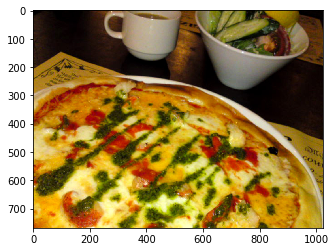

In [0]:
img = random.choice(os.listdir('/gdrive/My Drive/pizza/test/Pizza/'))
print(img)
img_path = '/gdrive/My Drive/pizza/test/Pizza/' + img
print(img_path)
with  Image.open(img_path) as image:
    plt.imshow(image)
    
prob, classes = predict(img_path, model, topk=2)

Number of GPUs: 1
Device name: Tesla P100-PCIE-16GB
tensor([[[-1.9124, -1.8782, -1.8268,  ..., -1.6384, -1.4158, -1.2617],
         [-1.9124, -1.8953, -1.8439,  ..., -1.5528, -1.5528, -1.6555],
         [-1.9124, -1.9124, -1.8610,  ..., -1.1760, -1.2445, -1.5699],
         ...,
         [ 0.0569,  0.2796,  0.4851,  ..., -1.1760, -1.1589, -1.1075],
         [ 0.4337,  0.5707,  0.5878,  ..., -1.0048, -0.9877, -0.7479],
         [ 0.6049,  0.7419,  0.4679,  ..., -0.7822, -0.8849, -0.6623]],

        [[-1.9307, -1.9132, -1.9132,  ..., -1.4755, -1.1954, -0.9678],
         [-1.9482, -1.9132, -1.8957,  ..., -1.4055, -1.4580, -1.4055],
         [-1.9482, -1.9132, -1.9132,  ..., -1.0028, -1.0903, -1.3529],
         ...,
         [-1.2129, -0.9678, -0.8277,  ..., -1.2654, -1.2304, -1.1604],
         [-1.1253, -0.9153, -0.6352,  ..., -1.1253, -0.9678, -0.7052],
         [-1.0378, -0.7227, -0.6001,  ..., -0.8102, -0.8277, -0.6352]],

        [[-1.6999, -1.6824, -1.6999,  ..., -1.5779, -1.4907, -1.

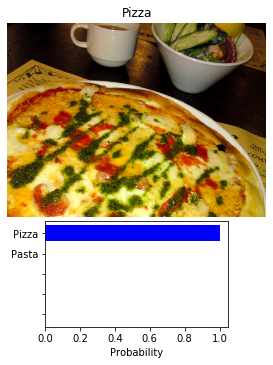

In [0]:
from torch.autograd import Variable
prob, classes = predict(img_path, model)
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]

fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

image = Image.open(img_path)
ax1.axis('off')
val_list = list(cat_to_name.values())
print(cat_to_name) 
print(cat_to_name[str(val_list.index(label))])
ax1.set_title(cat_to_name[str(val_list.index(label))])
ax1.imshow(image)

labels = []
print(classes)
for cl in classes:
    labels.append(cat_to_name[str(val_list.index(cl))])

print("labels", labels)
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
print(prob)
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')

plt.show()  